In [1]:
!pip install ISLP -q
!pip install l0bnb linearmodels matplotlib seaborn scikit-learn xgboost lightgbm -q
!pip install --upgrade econml -q
!pip install causalinference dowhy tabulate -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygam 0.9.1 requires numpy>=1.25; python_version >= "3.9" and python_version < "3.13", but you have numpy 1.24.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
linearmodels 6.1 requires Cython>=3.0.10, but you have cython 0.29.37 which is incompatible.


In [2]:
import dowhy
import networkx as nx
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy

from matplotlib.cm import get_cmap
from matplotlib.pyplot import subplots

from statsmodels.api import OLS

from sklearn.model_selection import train_test_split, cross_val_predict
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import (
    DecisionTreeRegressor as DTR,
    plot_tree,
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor

from joblib import Parallel, delayed

from dowhy import CausalModel

from ISLP.models import ModelSpec as MS, Stepwise, sklearn_selected, sklearn_selection_path
from l0bnb import fit_path

from tabulate import tabulate

from econml.grf import CausalForest

In [3]:
#Cumulative gain plot functions from CIBT-21-Meta-Learners Notebook (ECO2425 Materials Week 8)
from toolz import curry
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))


def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [4]:
np.random.seed(88)
random_st = 55

In [5]:
control_names = {
    'avg_cloud_coverage': 'Average Cloud Coverage',
    'avg_rainfall_millimeter': 'Average Rainfall (mm)',
    'avg_temperature': 'Average Temperature',
    'BBC_SNR_Ratio': 'BBC SNR Ratio',
    'popul_000s': 'Population',
    'female_share': '% Female',
    'illit_share': '% Illiterate'  
}

graph_names_1921 = {**{
    'share_socialist1921': 'Socialist Share (1921)',
    'share_republican1921': 'Republican Share (1921)',
    'share_catholic1921': 'Christian Share (1921)',
    'share_communist1921': 'Communist Share (1921)',
    'share_independent1921': 'Independent Share (1921)',
    'share_altri1921': 'Other Parties Share (1921)',
    'aggregated_share1921': 'Right-Wing Share (1921)',
},  **control_names}


parties_1921 = ['share_republican1921', 'share_socialist1921', 
                'share_catholic1921', 'share_communist1921', 
                'share_independent1921', 'share_altri1921']


Data Prep

In [6]:
main_data = pd.read_stata("OG Full Dataset.dta")
restricted = main_data[(main_data['date']<=29) & (main_data['date']>=10) &
                       (main_data['gustav']>=1) & (main_data['dist_lib']>=-1) & 
                        (main_data['dist_lib']<=10)]

In [7]:
restricted = restricted.rename(columns = {"vict_rappr_aggr_AT_ep": "violence_episode_total", 
                                                          "vict_rappr_aggr_civ_AT_ep": "violence_episode_civilian_resistance", 
                                                          "vict_rappr_aggr_part_AT_ep": "violence_episode_partisan_resistance" })

restricted = restricted.rename(columns = {"MW_SNR": "BBC_SNR_Ratio",
                                         "rain": "avg_rainfall_millimeter",
                                         "cloud": "avg_cloud_coverage", 
                                         "temp": "avg_temperature",
                                         "popres_1951_tot": "popul_000s",
                                         "female_share_1951": "female_share",
                                         "analfshare_1951_tot": "illit_share"})

restricted.rename(columns=lambda x: x.replace('p_voti2_liberali', 'share_liberal') if 'p_voti2_liberali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_socialisti', 'share_socialist') if 'p_voti2_socialisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_cattolici', 'share_catholic') if 'p_voti2_cattolici' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_comunisti', 'share_communist') if 'p_voti2_comunisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_fascisti', 'share_fascist') if 'p_voti2_fascisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_destra', 'share_conservative') if 'p_voti2_destra' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_autonomisti', 'share_independent') if 'p_voti2_autonomisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_altri', 'share_altri') if 'p_voti2_altri' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_radicali', 'share_radical') if 'p_voti2_radicali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_repubblicani', 'share_republican') if 'p_voti2_repubblicani' in x else x, inplace=True)

restricted = restricted.loc[:, restricted.columns.str.contains('|'.join(['dist_lib', '1924', '1921', '1919', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 'cod_istat103', 
                                                                         'violence_episode', 'popul_000s', 'female_share', 'illit_share']))]
restricted = restricted.loc[:, ~restricted.columns.str.contains('_miss|_l01|_lgt1|dist_lib_abs')]

print(restricted.columns.tolist())

['cod_istat103', 'dist_lib', 'violence_episode_total', 'violence_episode_civilian_resistance', 'violence_episode_partisan_resistance', 'BBC_SNR_Ratio', 'avg_rainfall_millimeter', 'avg_cloud_coverage', 'avg_temperature', 'illit_share', 'female_share', 'popul_000s', 'share_liberal1919', 'share_conservative1919', 'share_catholic1919', 'share_socialist1919', 'share_radical1919', 'share_republican1919', 'share_fascist1919', 'share_communist1919', 'share_independent1919', 'share_altri1919', 'share_liberal1921', 'share_conservative1921', 'share_catholic1921', 'share_socialist1921', 'share_radical1921', 'share_republican1921', 'share_fascist1921', 'share_communist1921', 'share_independent1921', 'share_altri1921', 'share_liberal1924', 'share_conservative1924', 'share_catholic1924', 'share_socialist1924', 'share_radical1924', 'share_republican1924', 'share_fascist1924', 'share_communist1924', 'share_independent1924', 'share_altri1924']


In [8]:
print("N:", len(restricted))
assert np.isinf(restricted).any(axis=1).sum() == 0
print("N with NAs:", restricted.isna().any(axis=1).sum())

restricted_na = restricted[restricted.isna().any(axis=1)].isna().sum()
print(restricted_na)

#156 obs of 66k are missing elections data - less than 0.25%, can drop from analysis
main_analysis = restricted.dropna()
print("N (clean):", len(main_analysis))

N: 66297
N with NAs: 156
cod_istat103                              0
dist_lib                                  0
violence_episode_total                    0
violence_episode_civilian_resistance      0
violence_episode_partisan_resistance      0
BBC_SNR_Ratio                             0
avg_rainfall_millimeter                   0
avg_cloud_coverage                        0
avg_temperature                           0
illit_share                               0
female_share                              0
popul_000s                                0
share_liberal1919                       156
share_conservative1919                  156
share_catholic1919                      156
share_socialist1919                     156
share_radical1919                       156
share_republican1919                    156
share_fascist1919                       156
share_communist1919                     156
share_independent1919                   156
share_altri1919                         156
share_l

II. Data Summary

In [9]:
reg_data = main_analysis.copy()
reg_data['aggregated_share1919'] = reg_data['share_liberal1919'] + reg_data['share_conservative1919'] + reg_data['share_radical1919']
reg_data['aggregated_share1921'] = reg_data['share_liberal1921'] + reg_data['share_conservative1921'] + reg_data['share_fascist1921'] + reg_data['share_radical1921']
reg_data['aggregated_share1924'] = reg_data['share_liberal1924'] + reg_data['share_conservative1924'] + reg_data['share_fascist1924'] + reg_data['share_radical1924']
reg_data = reg_data.loc[:, ~reg_data.columns.str.contains('|'.join(['share_liberal', 'share_conservative', 'share_fascist', 'share_radical']))]
reg_data = reg_data.drop(['share_communist1919', 'share_independent1919', 'share_altri1919', 'share_altri1924'], axis=1)

In [10]:
y = reg_data['violence_episode_total']

y_stat = pd.DataFrame({
    'Mean': [y.mean()],
    'Median': [y.median()],
    'Standard Deviation': [y.std()],
    'Range': [y.max() - y.min()]
})

print(y_stat)

      Mean  Median  Standard Deviation  Range
0  0.05269     0.0            0.348772     17


In [11]:
expl = reg_data.loc[:, reg_data.columns.str.contains('|'.join(['share_', 'aggregated_share']))]

pd.DataFrame({
        'Mean': expl.mean(),
        'Median': expl.median(),
        'Standard Deviation': expl.std(),
        'Range': expl.max() - expl.min()
    })

,Mean,Median,Standard Deviation,Range
share_catholic1919,0.312680,0.257426,0.209821,1.075244
share_socialist1919,0.258327,0.200388,0.260045,1.000000
share_republican1919,0.006111,0.000000,0.038638,0.678832
share_catholic1921,0.298785,0.259740,0.195706,1.000000
share_socialist1921,0.227981,0.182595,0.226788,1.000000
share_republican1921,0.008165,0.000000,0.040436,0.621589
share_communist1921,0.031051,0.000000,0.069989,0.857576
share_independent1921,0.000155,0.000000,0.003224,0.186633
share_altri1921,0.000206,0.000000,0.003171,0.113636
share_catholic1924,0.149738,0.103964,0.147932,1.000000


In [12]:
controls_sum = reg_data.loc[:, ~reg_data.columns.str.contains('|'.join(['dist_lib', 'cod_istat103','share_', 'aggregated_share', 'violence']))]

pd.DataFrame({
        'Mean': controls_sum.mean(),
        'Median': controls_sum.median(),
        'Standard Deviation': controls_sum.std(),
        'Range': controls_sum.max() - controls_sum.min()
    })

,Mean,Median,Standard Deviation,Range
BBC_SNR_Ratio,59.387550,59.500000,5.403883,29.000000
avg_rainfall_millimeter,71.861458,55.400002,64.012100,382.500000
avg_cloud_coverage,57.239983,58.700001,8.742622,46.200001
avg_temperature,11.671016,11.700000,8.076022,39.100000
illit_share,0.057002,0.036347,0.055485,0.574884
female_share,0.503025,0.502339,0.019318,0.261095
popul_000s,5.540282,2.465000,32.188262,1651.679000


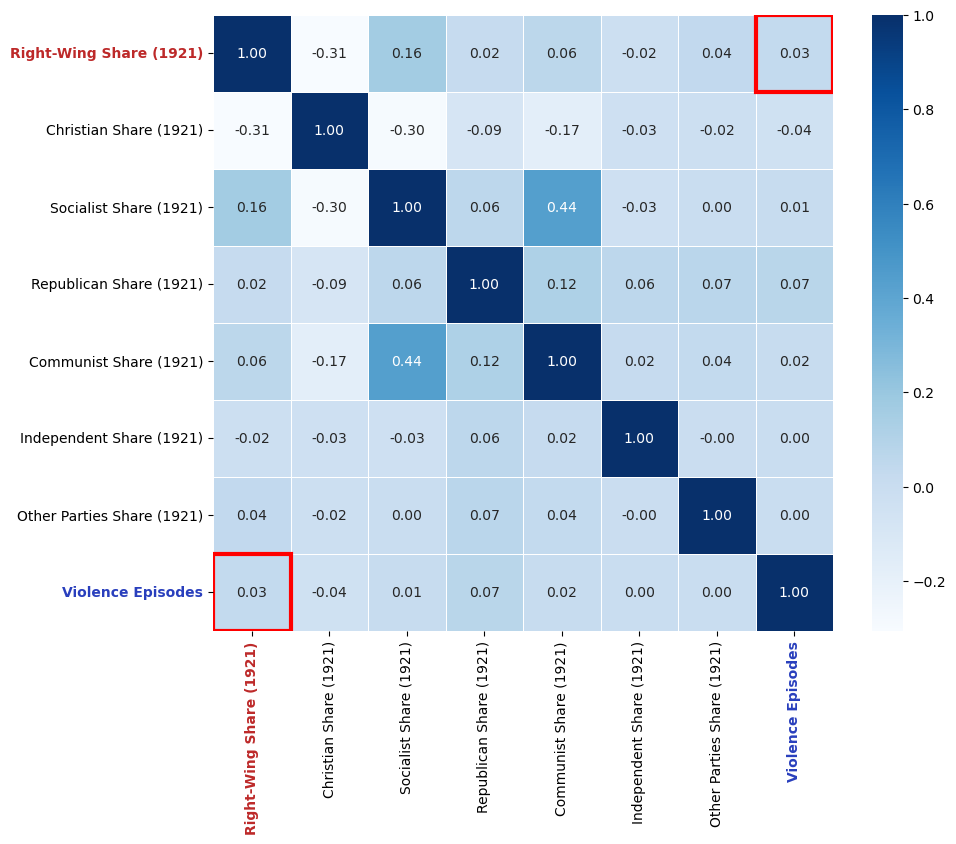

In [13]:
corrheat_1921 = reg_data[['aggregated_share1921', 'share_catholic1921', 'share_socialist1921',
                              'share_republican1921', 'share_communist1921', 'share_independent1921',
                              'share_altri1921', 'violence_episode_total']]

corrheat_1921 = corrheat_1921.rename(columns={**graph_names_1921,  **{'violence_episode_total': 'Violence Episodes'}})
corrheat_1921 = corrheat_1921.corr()

plt.figure(figsize=(10, 8))
corr_plot = sns.heatmap(corrheat_1921, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

corr_plot.get_xticklabels()[0].set_color('#bd2929')
corr_plot.get_yticklabels()[0].set_color('#bd2929')

corr_plot.get_xticklabels()[-1].set_color('#293fbd')
corr_plot.get_yticklabels()[-1].set_color('#293fbd')

corr_plot.get_xticklabels()[0].set_fontweight('bold')
corr_plot.get_yticklabels()[0].set_fontweight('bold')

corr_plot.get_xticklabels()[-1].set_fontweight('bold')
corr_plot.get_yticklabels()[-1].set_fontweight('bold')

rw = corrheat_1921.columns.get_loc('Right-Wing Share (1921)')
vi = corrheat_1921.columns.get_loc('Violence Episodes')

bl = plt.Rectangle((0, len(corrheat_1921) - 1), 1, 1, fill=False, edgecolor='red', lw = 3)
tr = plt.Rectangle((len(corrheat_1921) - 1, 0), 1, 1, fill=False, edgecolor='red', lw = 3)
corr_plot.add_patch(bl)
corr_plot.add_patch(tr)

Text(20.265625000000007, 0.5, 'Fraction of Illiterate Population')

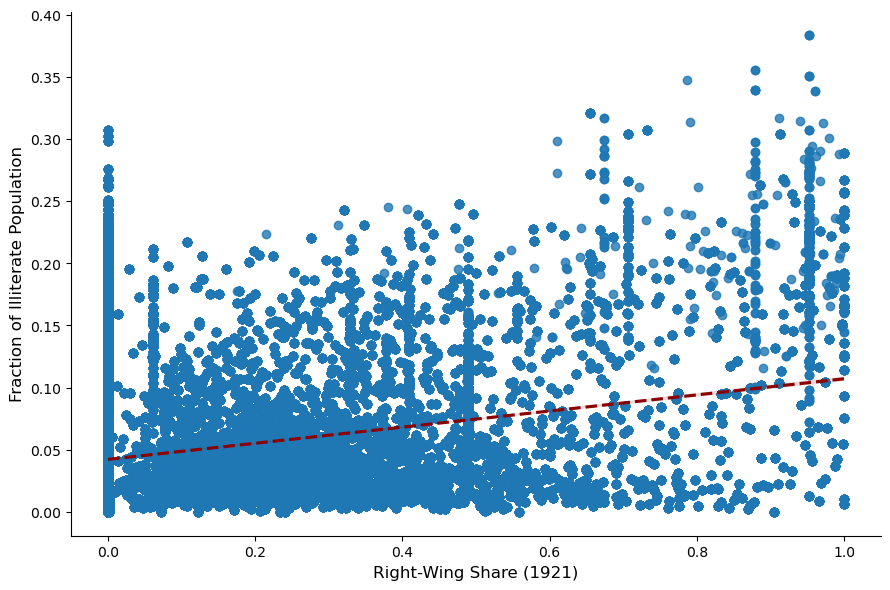

In [14]:
filt_illit = reg_data[reg_data['illit_share'] < 0.5]
sns.lmplot(x='aggregated_share1921', y='illit_share', data=filt_illit, aspect=1.5, height=6, 
           line_kws={'color': 'darkred', 'linestyle': '--'})

plt.xlabel('Right-Wing Share (1921)', fontsize=12)
plt.ylabel('Fraction of Illiterate Population', fontsize=12)

Text(20.265625000000007, 0.5, 'Fraction of Female Population')

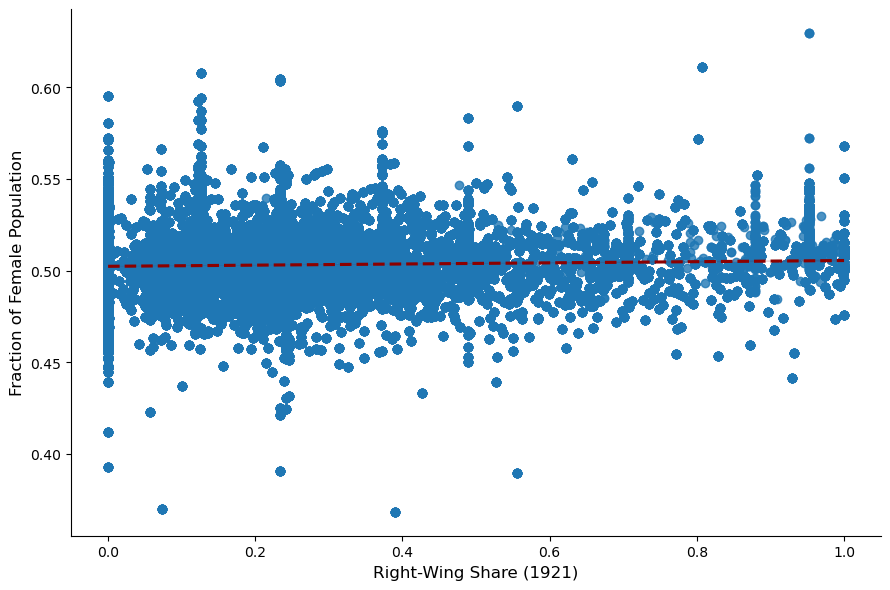

In [15]:
sns.lmplot(x='aggregated_share1921', y='female_share', data=reg_data, aspect=1.5, height=6, 
           line_kws={'color': 'darkred', 'linestyle': '--'})

plt.xlabel('Right-Wing Share (1921)', fontsize=12)
plt.ylabel('Fraction of Female Population', fontsize=12)

Text(42.39062500000001, 0.5, 'Violence Episodes per Capita')

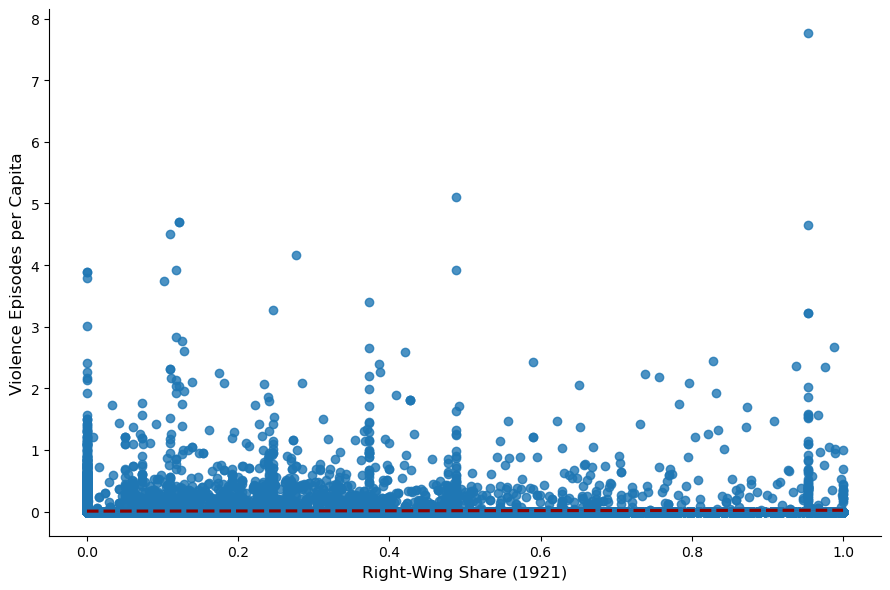

In [16]:
scatter_data = reg_data.copy()
scatter_data['violence_per_capita'] = scatter_data['violence_episode_total'] / scatter_data['popul_000s']
sns.lmplot(x='aggregated_share1921', y='violence_per_capita', data=scatter_data, aspect=1.5, height=6, 
           line_kws={'color': 'darkred', 'linestyle': '--'})

plt.xlabel('Right-Wing Share (1921)', fontsize=12)
plt.ylabel('Violence Episodes per Capita', fontsize=12)

Text(29.140625000000007, 0.5, 'Violence Episodes per Capita')

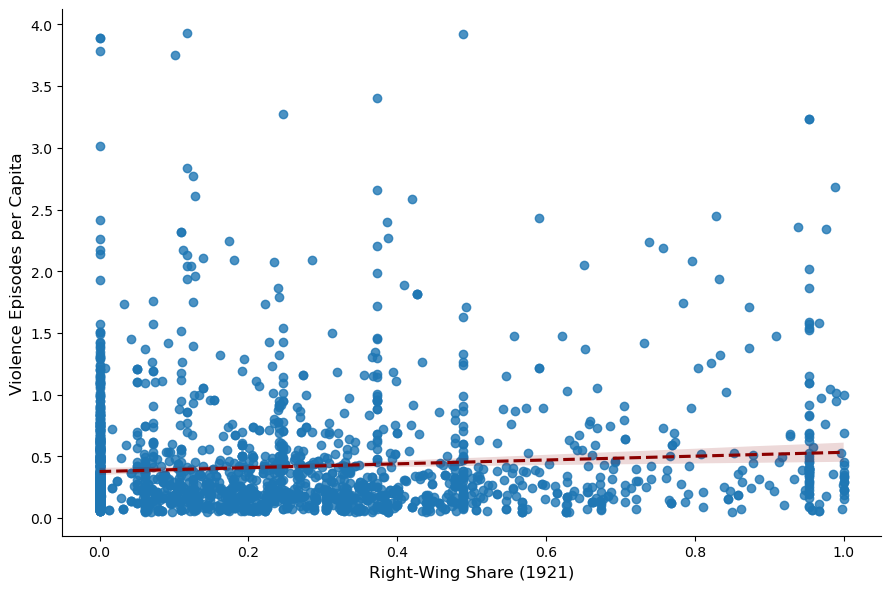

In [17]:
filt = scatter_data[(scatter_data['violence_per_capita'] > 0.05) & (scatter_data['violence_per_capita'] < 4)]
sns.lmplot(x='aggregated_share1921', y='violence_per_capita', data=filt, aspect=1.5, height=6, 
           line_kws={'color': 'darkred', 'linestyle': '--'})

plt.xlabel('Right-Wing Share (1921)', fontsize=12)
plt.ylabel('Violence Episodes per Capita', fontsize=12)

III. Models

[Model 8] Directed Acyclic Graphs (DAGs)

In [18]:
iv_gml = """graph [
directed 1
node [
    id 3
    label "Right Wing %"
]    
node [
    id 1
    label "Reprisals"
] 
node [
    id 2
    label "Weather"
]
node [
    id 0
    label "Radio"
]
node [
    id 4
    label "Population"
]

node [
    id 5
    label "% Illiterate"
]
node [
    id 6
    label "Other Parties %"
]    
edge [
    source 0
    target 1
]  
edge [
    source 5
    target 3
]
edge [
    source 4
    target 1
    ]    
edge [
    source 4
    target 3
]   
edge [
    source 2
    target 1
]   

edge [
    source 3
    target 1
]
edge [
    source 0
    target 3
]
edge [
    source 2
    target 3
]  
edge [
    source 6
    target 1
    ]    
edge [
    source 6
    target 3
]   
]
"""

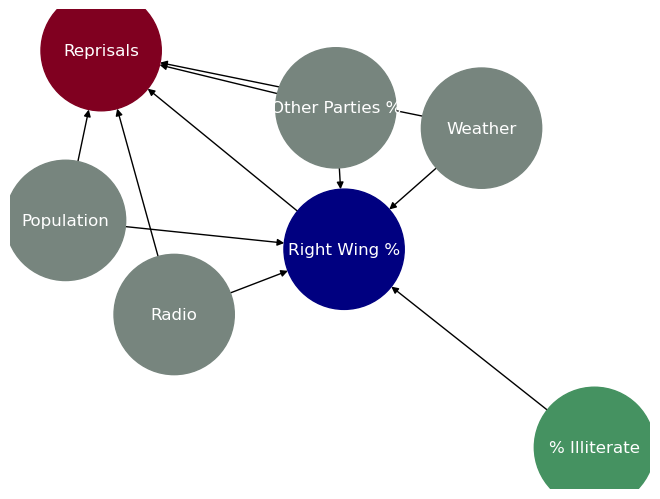

In [19]:
iv = nx.parse_gml(iv_gml) 
nx.draw(G=iv, with_labels=True, node_size=7500,  node_color= ['#000080', '#800020', '#77857E', '#77857E' , '#77857E', '#459261',  '#77857E'],  font_color='white')

In [20]:
non_iv_gml = """graph [
directed 1
node [
    id 3
    label "Party Vote %"
]    
node [
    id 1
    label "Reprisals"
] 
node [
    id 2
    label "Weather"
]
node [
    id 0
    label "Radio"
]
node [
    id 4
    label "Population"
]

node [
    id 5
    label "% Illiterate"
]
node [
    id 6
    label "Other Parties %"
]    
edge [
    source 0
    target 1
]  
edge [
    source 5
    target 3
]
edge [
    source 5
    target 1
]
edge [
    source 4
    target 1
    ]    
edge [
    source 4
    target 3
]   
edge [
    source 2
    target 1
]   

edge [
    source 3
    target 1
]
edge [
    source 0
    target 3
]
edge [
    source 2
    target 3
]
edge [
    source 6
    target 3
]
edge [
    source 6
    target 1
] 
]
"""

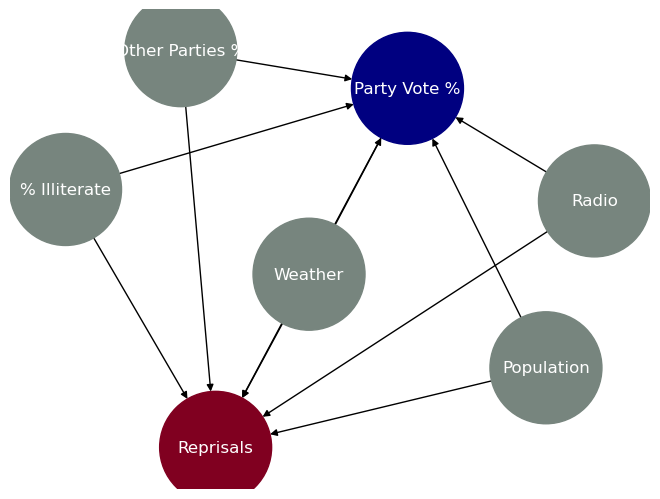

In [21]:
non_iv = nx.parse_gml(non_iv_gml) 
nx.draw(G=non_iv, with_labels=True, node_size=6500,  node_color= ['#000080', '#800020', '#77857E', '#77857E' , '#77857E', '#77857E', '#77857E'],  font_color='white')

[Models 1 & 2] OLS & IV Regressions

In [22]:
controls = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']

In [23]:
controls_1921 = ['1921'] + controls
x = reg_data.loc[:, reg_data.columns.str.contains('|'.join(controls_1921))]
y = reg_data['violence_episode_total']
x = sm.add_constant(x)
ols_1921 = sm.OLS(y, x).fit()
print(ols_1921.summary())

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.051
Model:                                OLS   Adj. R-squared:                  0.051
Method:                     Least Squares   F-statistic:                     252.9
Date:                    Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                            06:26:11   Log-Likelihood:                -22456.
No. Observations:                   66141   AIC:                         4.494e+04
Df Residuals:                       66126   BIC:                         4.508e+04
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [24]:
controls_1921_iv = reg_data.loc[:, reg_data.columns.str.contains('|'.join(controls_1921))].drop(columns='aggregated_share1921')

first_stage = sm.OLS(reg_data['aggregated_share1921'], 
                   sm.add_constant(controls_1921_iv)).fit()

print(first_stage.summary())

first_stage_fitted = first_stage.fittedvalues

second_stage = sm.OLS(reg_data['violence_episode_total'], 
                     sm.add_constant(controls_1921_iv.assign(illit_share_hat=first_stage_fitted))).fit()

print(second_stage.summary())

                             OLS Regression Results                             
Dep. Variable:     aggregated_share1921   R-squared:                       0.149
Model:                              OLS   Adj. R-squared:                  0.149
Method:                   Least Squares   F-statistic:                     892.6
Date:                  Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                          06:26:24   Log-Likelihood:                 8385.2
No. Observations:                 66141   AIC:                        -1.674e+04
Df Residuals:                     66127   BIC:                        -1.661e+04
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

[Models 3 & 4] LASSO

In [27]:
lasso_ridge_1921 = reg_data.loc[:, reg_data.columns.str.contains('|'.join(controls_1921 + ['violence_episode_total']))]
model_spec = MS(lasso_ridge_1921.columns.drop('violence_episode_total')).fit(lasso_ridge_1921)
dep = np.array(lasso_ridge_1921['violence_episode_total'])
expl_mf = model_spec.fit_transform(lasso_ridge_1921).drop('intercept', axis = 1)
expl = np.asarray(expl_mf)

expl_scaled = (expl - expl.mean(0)[None,:]) / (np.where(expl.std(0) == 0, 1e-10, expl.std(0)))[None, :]

reg_lambda = 10**np.linspace(9, -1, 100) / dep.std()

ridge_reg = skl.ElasticNet.path(expl_scaled,
                                 dep,
                                 l1_ratio=0.,
                                 alphas=reg_lambda)[1]

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4114.499999907954, tolerance: 0.8229000000000001
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did

/tmp/ipykernel_102/2386564866.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


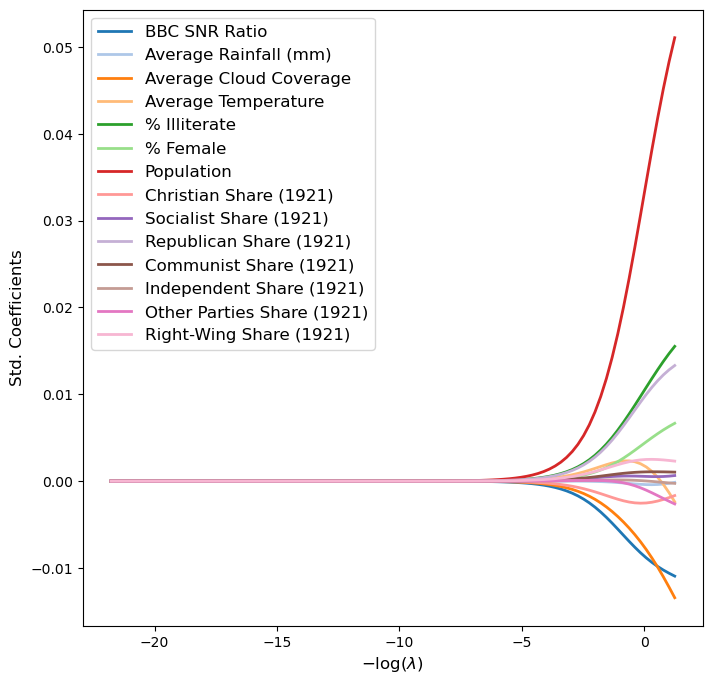

In [28]:
ridge_reg_df = pd.DataFrame(ridge_reg.T,
                         columns=expl_mf.columns,
                         index=-np.log( 10**np.linspace(9, -1, 100) / dep.std()))
ridge_reg_df.index.name = 'negative log(lambda)'

ridge_reg_df.rename(columns=graph_names_1921, inplace=True)

fig, lbls = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(ridge_reg_df.columns):
    ridge_reg_df[column].plot(ax=lbls, color=colormap(i % 20), linewidth=2, label=column)

lbls.set_xlabel('$-\log(\lambda)$', fontsize=12)
lbls.set_ylabel('Std. Coefficients', fontsize=12)
lbls.legend(loc='upper left', fontsize=12);

In [29]:
cv_model = Pipeline(steps=[('scaler', StandardScaler(with_mean=True,  with_std=True)),
                           ('ridge', skl.ElasticNet(alpha=reg_lambda[50], l1_ratio=0))])
cv_model.fit(expl, dep)
cv_fitted = skm.GridSearchCV(cv_model,
                        {'ridge__alpha': reg_lambda},
                        cv=skm.ShuffleSplit(n_splits=3,
                        test_size=0.25),
                        scoring='neg_mean_squared_error')
cv_fitted.fit(expl, dep)
cv_fitted.best_params_['ridge__alpha']
cv_fitted.best_estimator_

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.023e+03, tolerance: 8.045e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+03, tolerance: 5.876e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.28672282488638, l1_ratio=0))])

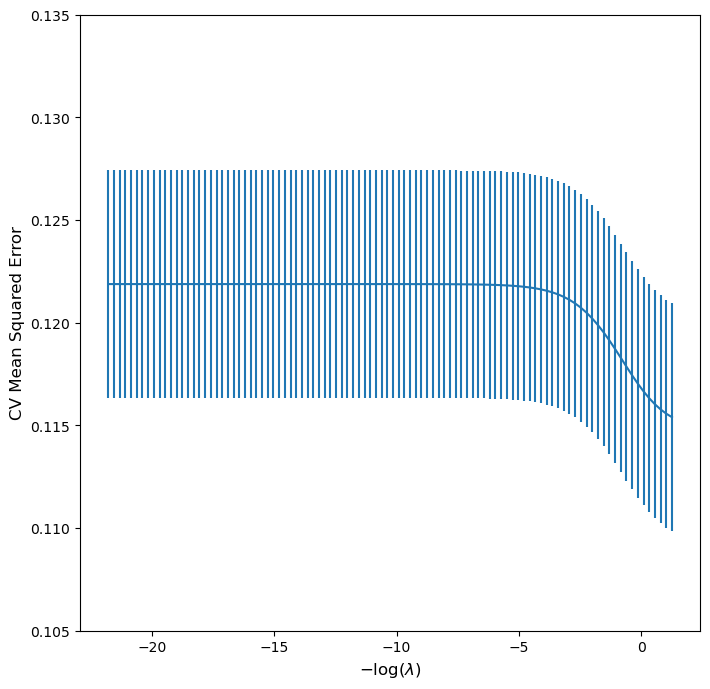

In [31]:
ridge_fig, lbls = subplots(figsize=(8,8))
lbls.errorbar(-np.log(reg_lambda),
            -cv_fitted.cv_results_['mean_test_score'],
            yerr=cv_fitted.cv_results_['std_test_score'] / np.sqrt(3))
lbls.set_ylim([0.105,0.135])
lbls.set_xlabel('$-\log(\lambda)$', fontsize=12)
lbls.set_ylabel('CV Mean Squared Error', fontsize=12);

/tmp/ipykernel_102/1322633521.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


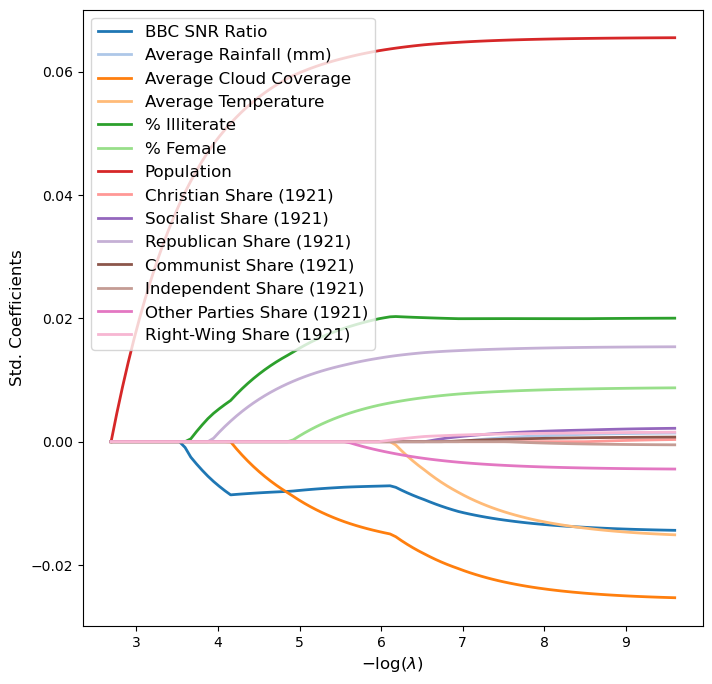

In [32]:
lasso_lambdas, lasso_reg = skl.Lasso.path(expl_scaled,
                                    dep,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]

lasso_reg_df = pd.DataFrame(lasso_reg.T,
                         columns=expl_mf.columns,
                         index=-np.log(lasso_lambdas))
lasso_reg_df.rename(columns = graph_names_1921, inplace = True)

fig, lbls = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(lasso_reg_df.columns):
    lasso_reg_df[column].plot(ax=lbls, color=colormap(i % 20), linewidth=2, label=column)

lbls.set_xlabel('$-\log(\lambda)$', fontsize=12)
lbls.set_ylabel('Std. Coefficients', fontsize=12)
lbls.legend(loc='upper left', fontsize=12);

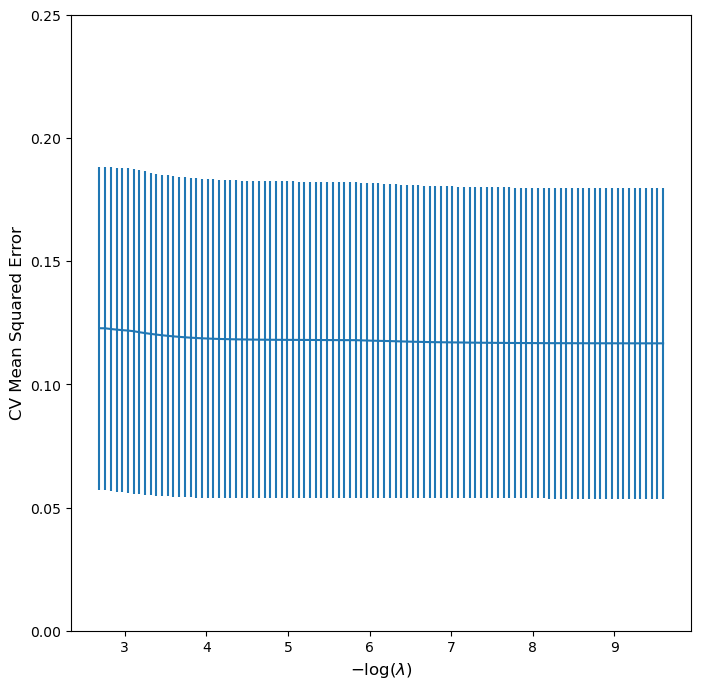

In [33]:
cv_model = Pipeline(steps=[('scaler', StandardScaler(with_mean=True,  with_std=True)),
                         ('lasso', skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=3))])
cv_model.fit(expl, dep)
cv_fitted = cv_model.named_steps['lasso']
lasso_fig, lbls = subplots(figsize=(8,8))
lbls.errorbar(-np.log(cv_fitted.alphas_),
            cv_fitted.mse_path_.mean(1),
            yerr=cv_fitted.mse_path_.std(1) / np.sqrt(3))
lbls.set_ylim([0.0,0.25])
lbls.set_xlabel('$-\log(\lambda)$', fontsize=12)
lbls.set_ylabel('CV Mean Squared Error', fontsize=12);

[Model 5] Tree-Based Model

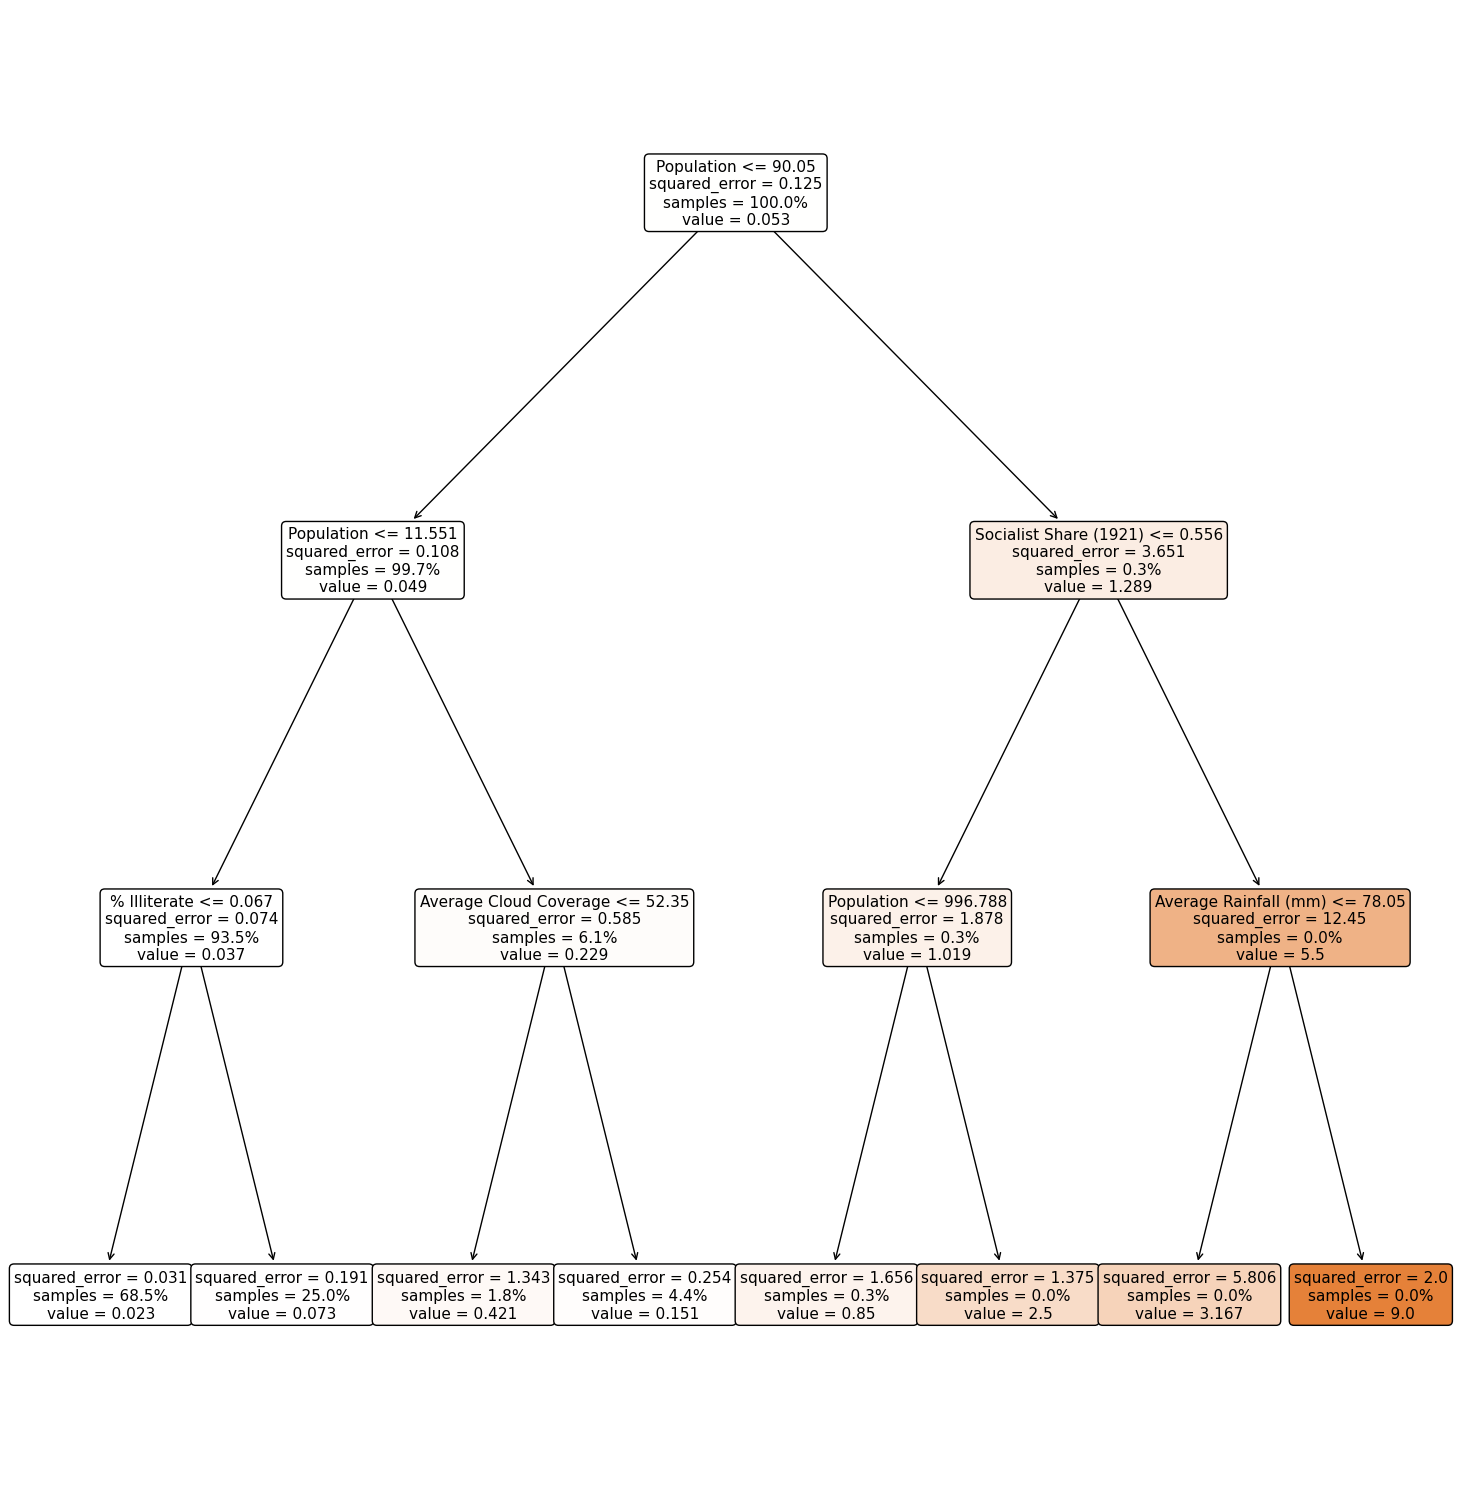

In [34]:
tree_2021 = reg_data.loc[:, reg_data.columns.str.contains('|'.join(controls_1921 + ['violence_episode_total']))]
tree_model = MS(tree_2021.columns.drop('violence_episode_total'), intercept=False)
expl_data = tree_model.fit_transform(reg_data)
expl = np.asarray(expl_data)

(expl_train, expl_test, dep_train, dep_test) = skm.train_test_split(expl_data,
                                tree_2021['violence_episode_total'],
                                test_size=0.25, random_state = random_st)
base_tree = DTR(max_depth=3, random_state = random_st)
base_tree.fit(expl_train, dep_train)

tree_fig, lbls = plt.subplots(figsize=(15, 15))
lbls_name = [graph_names_1921.get(name, name) for name in expl_data.columns]
plot_tree(base_tree,
          feature_names=lbls_name,
          filled=True, 
          rounded=True,
          proportion=True, 
          fontsize=11);
plt.tight_layout() 

In [35]:
prune_tree = base_tree.cost_complexity_pruning_path(expl_train, dep_train)
prune_model = skm.GridSearchCV(base_tree,
                        {'ccp_alpha': prune_tree.ccp_alphas},
                        refit=True,
                        cv= skm.KFold(5,
                            shuffle=True,
                            random_state = random_st),
                        scoring='neg_mean_squared_error')
prune_fitted = prune_model.fit(expl_train, dep_train)
pruned_tree = prune_fitted.best_estimator_
np.mean((dep_test - pruned_tree.predict(expl_test))**2)

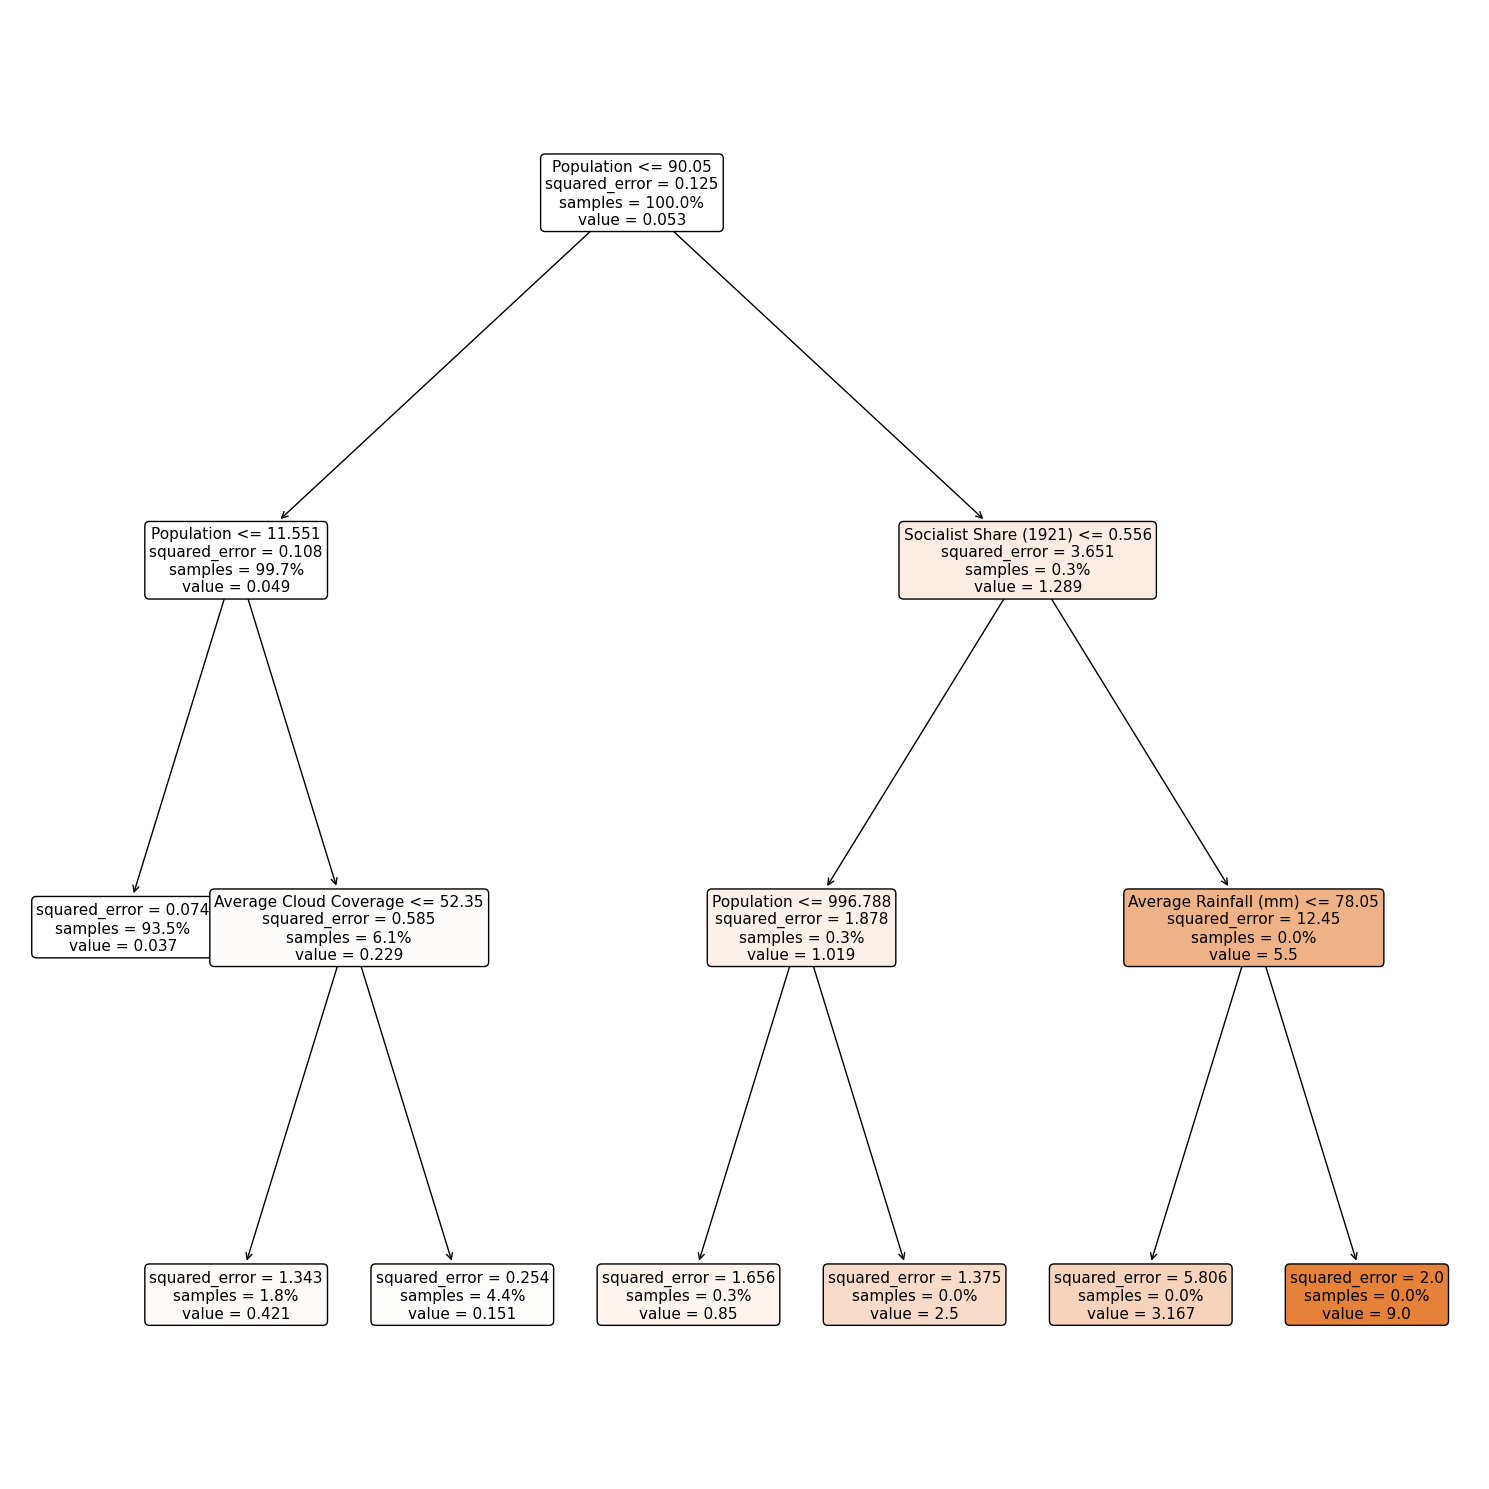

In [36]:
lbls = subplots(figsize=(15,15))[1]
plot_tree(prune_fitted.best_estimator_,
          feature_names=lbls_name,
          filled=True, 
          rounded=True,
          proportion=True, 
          fontsize=11);
plt.tight_layout() 

In [37]:
rf_expl = tree_2021.drop(['violence_episode_total'], axis = 1)
rf_dep = tree_2021['violence_episode_total']
random_f = RandomForestRegressor(max_features=5, random_state=random_st).fit(rf_expl, rf_dep)
rf_pr = random_f.predict(rf_expl)
mean_squared_error(rf_dep, rf_pr)

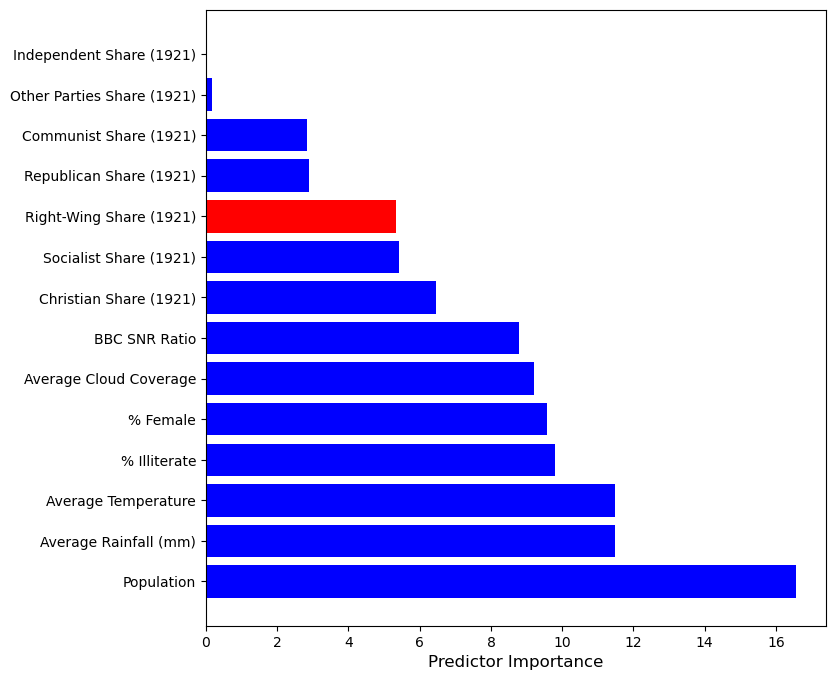

In [38]:
rf_imp = pd.DataFrame({'Predictor Importance':random_f.feature_importances_*100}, index=rf_expl.columns)
rf_imp.index = rf_imp.index.map(graph_names_1921)
rf_imp = rf_imp.sort_values('Predictor Importance', axis=0, ascending=False)
lbl_col = ['red' if l == 'Right-Wing Share (1921)' else 'blue' for l in rf_imp.index]

rf_imp_pl, lbls = plt.subplots(figsize=(8, 8))
rf_score = lbls.barh(rf_imp.index, rf_imp['Predictor Importance'], color=lbl_col)

plt.xlabel('Predictor Importance', fontsize = 12)
plt.gca().legend_ = None

In [39]:
boost = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,
    random_state=random_st
)

boost.fit(expl_train, dep_train)

GradientBoostingRegressor(max_depth=5, n_estimators=1000, random_state=55)

0.1051664679576247


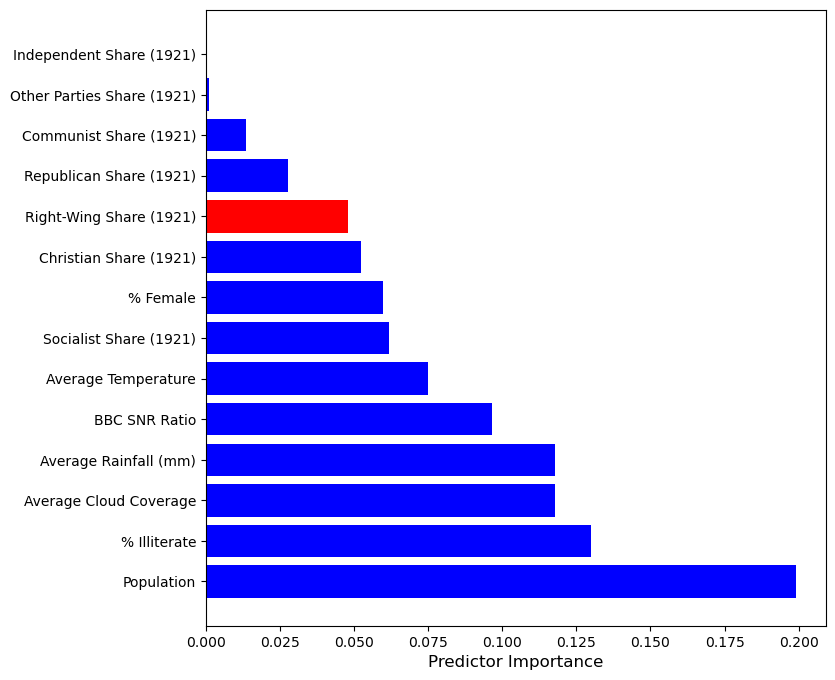

In [40]:
dep_pred = boost.predict(expl_test)
print(mean_squared_error(dep_test, dep_pred))

boost_imp = boost.feature_importances_
boost_imp_df = pd.DataFrame({'Predictor Importance': boost_imp}, index=rf_expl.columns).sort_values(by='Predictor Importance', ascending=False)
boost_imp_df.index = boost_imp_df.index.map(graph_names_1921)
lbl_col = ['red' if l == 'Right-Wing Share (1921)' else 'blue' for l in boost_imp_df.index]

boost_imp_pl, lbls = plt.subplots(figsize=(8, 8))
rf_score = lbls.barh(boost_imp_df.index, boost_imp_df['Predictor Importance'], color=lbl_col)

plt.xlabel('Predictor Importance', fontsize = 12)
plt.gca().legend_ = None

[Model 6] Matching

In [41]:
ml_data=reg_data.copy()
ml_data['above_median1921'] = (ml_data['aggregated_share1921'] > ml_data['aggregated_share1921'].median()).astype(int)

In [42]:
controls_matching = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']
match_data =ml_data.copy()
ate_controls = controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921']
match_data = match_data.assign(**{c: (match_data[c] - match_data[c].mean())/match_data[c].std() for c in ate_controls})
print(ate_controls)

['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share', 'share_republican1921', 'share_socialist1921', 'share_catholic1921', 'share_communist1921', 'share_independent1921', 'share_altri1921']


In [43]:
def match_f(match_data, ate_controls, match_t, match_y):
    low = match_data.query(f'{match_t} == 0')
    high = match_data.query(f'{match_t} == 1')
    
    mt_low = KNeighborsRegressor(n_neighbors=1).fit(low[ate_controls], low[match_y])
    mt_high = KNeighborsRegressor(n_neighbors=1).fit(high[ate_controls], high[match_y])
    
    ols_low = LinearRegression().fit(low[ate_controls], low[match_y])
    ols_high = LinearRegression().fit(high[ate_controls], high[match_y])
    
    high_match_index = mt_low.kneighbors(high[ate_controls], n_neighbors=1)[1].ravel()
    low_match_index = mt_high.kneighbors(low[ate_controls], n_neighbors=1)[1].ravel()
    
    matched = pd.concat([
        (high.assign(y_pred=mt_low.predict(high[ate_controls]))
             .assign(bias=ols_low.predict(high[ate_controls]) - 
                     ols_low.predict(low.iloc[high_match_index][ate_controls]))),
        (low.assign(y_pred=mt_high.predict(low[ate_controls]))
             .assign(bias=ols_high.predict(low[ate_controls]) - 
                     ols_high.predict(high.iloc[low_match_index][ate_controls])))
    ])
    
    atet = np.mean(
        (2 * matched[match_t] - 1) * 
        ((matched[match_y] - matched["y_pred"]) - matched["bias"])
    )
    return atet

match_f(match_data, ate_controls, 'above_median1921', 'violence_episode_total')

In [49]:
match_bootstrap = Parallel(n_jobs=2)(
    delayed(match_f)(
        match_data.sample(n = 16500, replace=True), ate_controls, 'above_median1921', 'violence_episode_total'
    ) for _ in range(100)
)

match_atet_bootstrap = np.array(match_bootstrap)

In [50]:
print(f"Bootstrap Mean: {np.mean(match_atet_bootstrap)}, Bootstrap SD: {np.std(match_atet_bootstrap)},  Bootstrap 2.5: {np.percentile(match_atet_bootstrap, 2.5)},  Bootstrap 97.5: {np.percentile(match_atet_bootstrap, 97.5)}")

Bootstrap Mean: -0.0036725968602283575, Bootstrap SD: 0.007292509603986889,  Bootstrap 2.5: -0.020245398133182588,  Bootstrap 97.5: 0.0071764675220646


/tmp/ipykernel_102/3824639655.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(match_atet_bootstrap, kde=False)


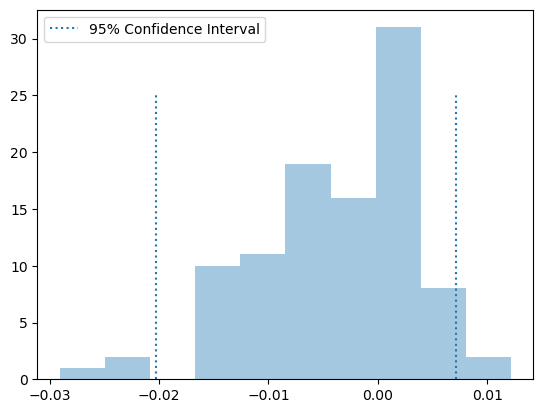

In [52]:
sns.distplot(match_atet_bootstrap, kde=False)
plt.vlines(np.percentile(match_atet_bootstrap, 2.5), 0, 25, linestyles="dotted")
plt.vlines(np.percentile(match_atet_bootstrap, 97.5), 0, 25, linestyles="dotted", label="95% Confidence Interval")
plt.legend();

In [53]:
pre_matching = ml_data.groupby('above_median1921')[ate_controls].mean()
post_matching = match_data.groupby('above_median1921')[ate_controls].mean()

low_before = pre_matching.query('above_median1921 == 0')
high_before = pre_matching.query('above_median1921 == 1')

low_after = post_matching.query('above_median1921 == 0')
high_after = post_matching.query('above_median1921 == 1')

balance = pd.concat([pre_matching.query('above_median1921 == 0').T,
                     pre_matching.query('above_median1921 == 1').T,
                     post_matching.query('above_median1921 == 0').T,
                     post_matching.query('above_median1921 == 1').T],
                     axis=1)

balance_latex = tabulate(balance, headers='keys', tablefmt='latex', floatfmt=".3f")
print(balance_latex)

\begin{tabular}{lrrrr}
\hline
                         &      0 &      1 &      0 &      1 \\
\hline
 avg\_cloud\_coverage      & 57.249 & 57.231 &  0.001 & -0.001 \\
 avg\_rainfall\_millimeter & 72.993 & 70.730 &  0.018 & -0.018 \\
 avg\_temperature         & 11.279 & 12.063 & -0.049 &  0.049 \\
 BBC\_SNR\_Ratio           & 59.730 & 59.045 &  0.063 & -0.063 \\
 popul\_000s              &  3.931 &  7.150 & -0.050 &  0.050 \\
 female\_share            &  0.503 &  0.503 &  0.008 & -0.008 \\
 illit\_share             &  0.051 &  0.063 & -0.116 &  0.116 \\
 share\_republican1921    &  0.007 &  0.010 & -0.040 &  0.040 \\
 share\_socialist1921     &  0.149 &  0.307 & -0.347 &  0.347 \\
 share\_catholic1921      &  0.344 &  0.254 &  0.229 & -0.229 \\
 share\_communist1921     &  0.018 &  0.044 & -0.183 &  0.183 \\
 share\_independent1921   &  0.000 &  0.000 &  0.029 & -0.029 \\
 share\_altri1921         &  0.000 &  0.000 & -0.049 &  0.049 \\
\hline
\end{tabular}


[Model 7] IPW

In [54]:
ipw_data = ml_data.copy()
ipw_x = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share'] + [party for party in parties_1921 if party != 'aggregated_share1921']
ipw_t = 'above_median1921'
ipw_y = 'violence_episode_total'

In [55]:
def ipw_bootstrap(ipw_data, ipw_x, ipw_t, ipw_y):
    
    ipw_lr_fit = LogisticRegression(C=1e6, max_iter=1000, random_state=random_st, penalty='l2').fit(ipw_data[ipw_x], ipw_data[ipw_t])
    
    ipw_data = ipw_data.assign(ps=ipw_lr_fit.predict_proba(ipw_data[ipw_x])[:, 1])
    
    high_w = 1 / ipw_data.query('above_median1921 == 1')["ps"]
    low_w = 1 / (1 - ipw_data.query('above_median1921 == 0')["ps"])

    w = ((ipw_data['above_median1921'] - ipw_data["ps"]) /
         (ipw_data["ps"] * (1 - ipw_data["ps"])))

    viol1 = sum(ipw_data.query('above_median1921 == 1')["violence_episode_total"] * high_w) / len(ipw_data)
    viol0 = sum(ipw_data.query('above_median1921 == 0')["violence_episode_total"] * low_w) / len(ipw_data)
    
    ate = np.mean(w * ipw_data["violence_episode_total"])
    
    return viol1, viol0, ate

/tmp/ipykernel_102/1502782447.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ipw_data.query('above_median1921==1')['ps'],
/tmp/ipykernel_102/1502782447.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ipw_data.query('above_median1921==0')['ps'],


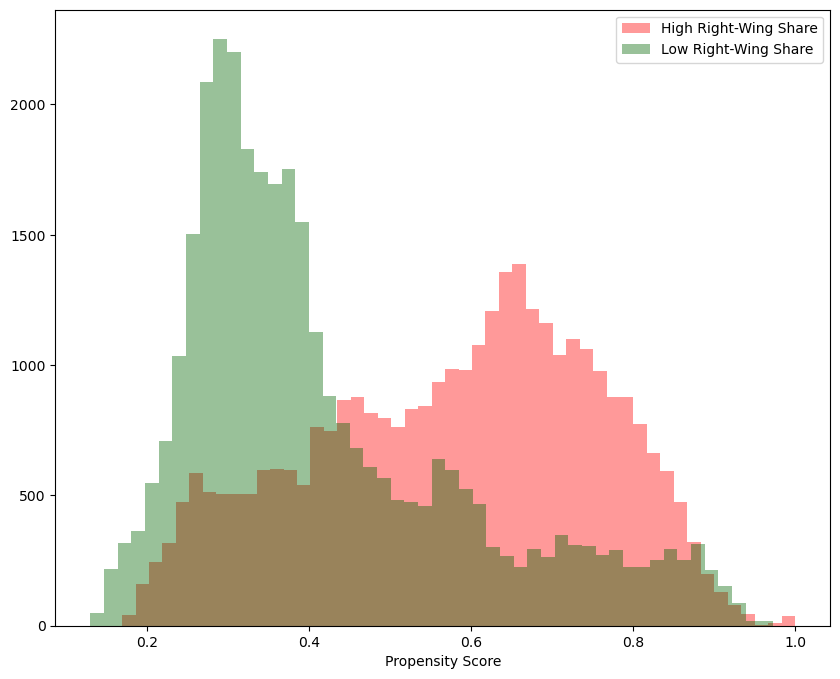

In [56]:
ipw_lr_fit = LogisticRegression(C=1e6, max_iter=1000, random_state=random_st, penalty='l2').fit(ipw_data[ipw_x], ipw_data[ipw_t])
    
ipw_data = ipw_data.assign(ps=ipw_lr_fit.predict_proba(ipw_data[ipw_x])[:, 1])
    
plt.figure(figsize=(10, 8))

sns.distplot(ipw_data.query('above_median1921==1')['ps'], 
                 kde=False, label="High Right-Wing Share", color="red")

sns.distplot(ipw_data.query('above_median1921==0')['ps'], 
                 kde=False, label="Low Right-Wing Share", color="darkgreen")

plt.xlabel('Propensity Score')
plt.legend()

In [57]:
ipw_atets = Parallel(n_jobs=2)(delayed(ipw_bootstrap)(
            ipw_data.sample(n=16500, replace=True), ipw_x, ipw_t, ipw_y)
                                    for _ in range(200))

ipw_atets = np.array(ipw_atets)

In [58]:
print(f"IPW Mean: {np.mean(ipw_atets)}, IPW SD: {np.std(ipw_atets)},  IPW 2.5: {np.percentile(ipw_atets, 2.5)},  IPW 97.5: {np.percentile(ipw_atets, 97.5)}")

IPW Mean: 0.033979119094721885, IPW SD: 0.028312697094344034,  IPW 2.5: -0.014779988047586163,  IPW 97.5: 0.06447284781908638


/tmp/ipykernel_102/3309824213.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ipw_atets, kde=False)


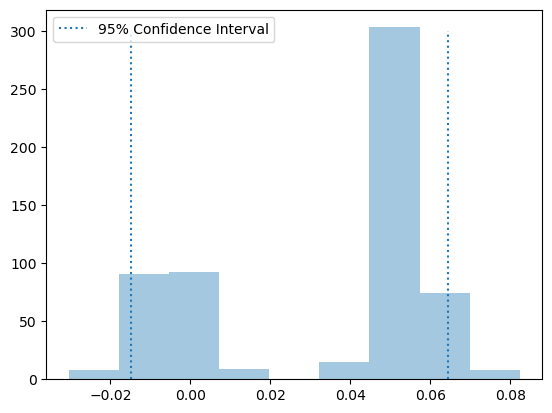

In [59]:
sns.distplot(ipw_atets, kde=False)
plt.vlines(np.percentile(ipw_atets, 2.5), 0, 300, linestyles="dotted")
plt.vlines(np.percentile(ipw_atets, 97.5), 0, 300, linestyles="dotted", label="95% Confidence Interval")
plt.legend();

[Model 9] Meta Learners

In [60]:
lgbm_max = 5
child = 150
learn_rate = 0.1

In [61]:
controls_matching = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']
meta_data =ml_data.copy()
meta_x = controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921']

meta_train, meta_test = train_test_split(meta_data, test_size=0.25, random_state=random_st)
meta_y = 'violence_episode_total' 
meta_t= 'above_median1921'
meta_train = meta_train[meta_x + [meta_y, meta_t]]
meta_test = meta_test[meta_x + [meta_y, meta_t]]

logit = LogisticRegression(solver="lbfgs", penalty='l2', max_iter=1000, random_state = random_st) 

ml_z = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
ml_o = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
ml_z.fit(meta_train.query('above_median1921 == 0')[meta_x], meta_train.query('above_median1921 == 0')[meta_y])
ml_o.fit(meta_test.query('above_median1921 == 1')[meta_x], meta_test.query('above_median1921 == 1')[meta_y])                   
logit.fit(meta_train[meta_x], meta_train[meta_t]);

d_tr = np.where(meta_train[meta_t]==0,
                   ml_o.predict(meta_train[meta_x]) - meta_train[meta_y],
                   meta_train[meta_y] - ml_z.predict(meta_train[meta_x]))

s_ml_z = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
s_ml_o = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)

s_ml_z.fit(meta_train.query('above_median1921 == 0')[meta_x], d_tr[meta_train[meta_t]==0])
s_ml_o.fit(meta_train.query('above_median1921 == 1')[meta_x], d_tr[meta_train[meta_t]==1]);

x_meta_train_cate = (logit.predict_proba(meta_train[meta_x])[:, 1]*s_ml_z.predict(meta_train[meta_x]) +
                logit.predict_proba(meta_train[meta_x])[:, 0]*s_ml_o.predict(meta_train[meta_x]))

x_meta_test_cate = meta_test.assign(
    cate=(
        logit.predict_proba(meta_test[meta_x])[:, 1] * s_ml_z.predict(meta_test[meta_x]) +
        logit.predict_proba(meta_test[meta_x])[:, 0] * s_ml_o.predict(meta_test[meta_x])
    )
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 24838, number of used features: 13
[LightGBM] [Info] Start training from score 0.044045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

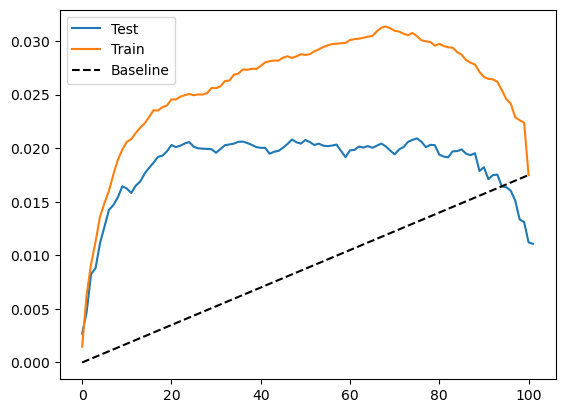

In [62]:
x_meta_test_curve = cumulative_gain(x_meta_test_cate, "cate", y=meta_y, t=meta_t)
x_meta_train_curve = cumulative_gain(meta_train.assign(cate=x_meta_train_cate), "cate", y=meta_y, t=meta_t)
plt.plot(x_meta_test_curve, color="C0", label="Test")
plt.plot(x_meta_train_curve, color="C1", label="Train")
plt.plot([0, 100], [0, elast(meta_train, meta_y, meta_t)], linestyle="--", color="black", label="Baseline")
plt.legend();

Text(0, 0.5, 'HTE')

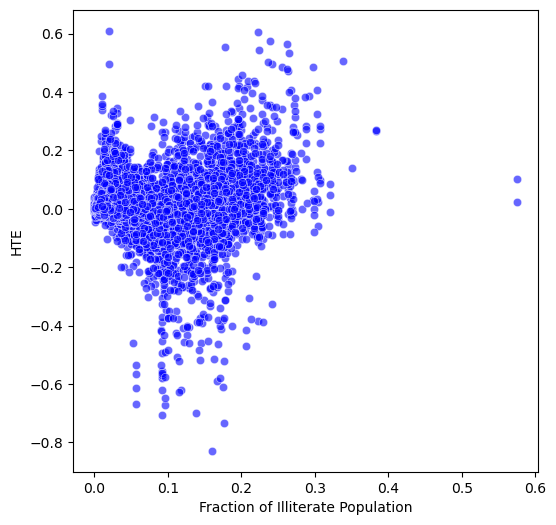

In [63]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=x_meta_test_cate, x='illit_share', y='cate', color = 'blue', alpha=0.6)
plt.xlabel('Fraction of Illiterate Population')
plt.ylabel('HTE')

Text(0, 0.5, 'HTE')

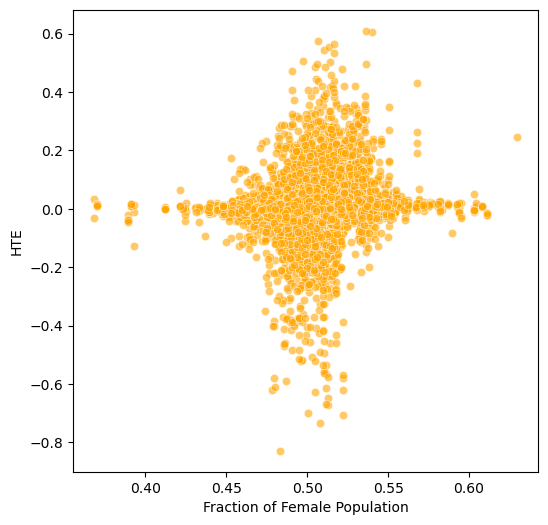

In [64]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=x_meta_test_cate, x='female_share', y='cate', color = 'orange', alpha=0.6)
plt.xlabel('Fraction of Female Population')
plt.ylabel('HTE')

In [65]:
meta_train, meta_test = train_test_split(meta_data, test_size=0.25, random_state=55)
meta_train = meta_train[meta_x + [meta_y, meta_t]]
meta_test = meta_test[meta_x + [meta_y, meta_t]]

t_0 = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state = random_st)
t_1 = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state = random_st)

t_0.fit(meta_train.query('above_median1921 == 0')[meta_x], meta_train.query('above_median1921 == 0')[meta_y])
t_1.fit(meta_train.query('above_median1921 == 1')[meta_x], meta_train.query('above_median1921 == 1')[meta_y])

t_meta_train_cate = t_1.predict(meta_train[meta_x]) - t_0.predict(meta_train[meta_x])
t_meta_test_cate = meta_test.assign(cate=t_1.predict(meta_test[meta_x]) - t_0.predict(meta_test[meta_x]))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 24838, number of used features: 13
[LightGBM] [Info] Start training from score 0.044045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

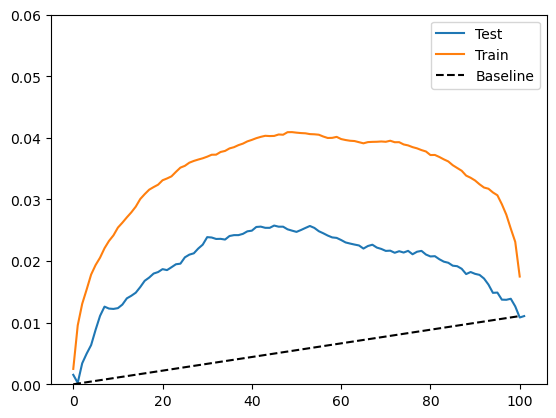

In [66]:
t_meta_test_curve = cumulative_gain(t_meta_test_cate, "cate", y=meta_y, t=meta_t)
t_meta_train_curve = cumulative_gain(meta_train.assign(cate=t_meta_train_cate), "cate", y=meta_y, t=meta_t)
plt.plot(t_meta_test_curve, color="C0", label="Test")
plt.plot(t_meta_train_curve, color="C1", label="Train")
plt.plot([0, 100], [0, elast(meta_test, meta_y, meta_t)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.ylim(0, 0.06);

Text(0, 0.5, 'HTE')

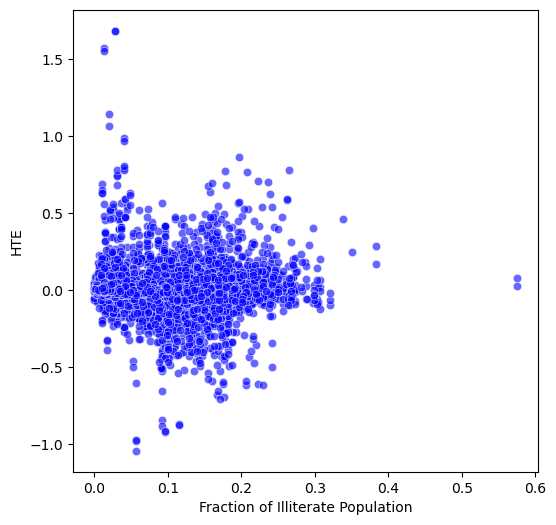

In [67]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=t_meta_test_cate, x='illit_share', y='cate', color = 'blue', alpha=0.6)
plt.xlabel('Fraction of Illiterate Population')
plt.ylabel('HTE')

Text(0, 0.5, 'HTE')

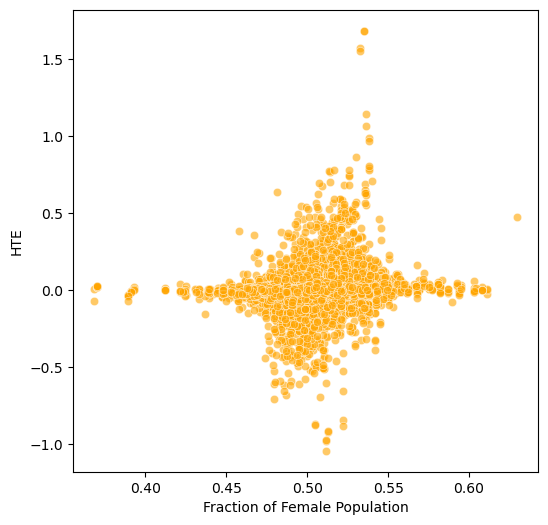

In [68]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=t_meta_test_cate, x='female_share', y='cate', color = 'orange', alpha=0.6)
plt.xlabel('Fraction of Female Population')
plt.ylabel('HTE')

In [69]:
controls_matching = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']

meta_x = controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921']

xy = ['violence_episode_total', 'above_median1921']
ns = xy +meta_x

dirs = []

for v in meta_x:
    for x in xy:
        dirs.append((v, x))

dirs = dirs + [('above_median1921', 'violence_episode_total')]
        
print(dirs)

meta_graph = 'graph [directed 1\n'
for n in ns:
    meta_graph += f'\tnode [id "{n}" label "{n}"]\n'
for d in dirs:
    meta_graph += f'\tedge [source "{d[0]}" target "{d[1]}"]\n'
meta_graph += ']'

meta_cate = CausalModel(
    data=meta_test,
    treatment='above_median1921',
    outcome='violence_episode_total',
    effect_modifiers=meta_x,
    graph=meta_graph
)

[('avg_cloud_coverage', 'violence_episode_total'), ('avg_cloud_coverage', 'above_median1921'), ('avg_rainfall_millimeter', 'violence_episode_total'), ('avg_rainfall_millimeter', 'above_median1921'), ('avg_temperature', 'violence_episode_total'), ('avg_temperature', 'above_median1921'), ('BBC_SNR_Ratio', 'violence_episode_total'), ('BBC_SNR_Ratio', 'above_median1921'), ('popul_000s', 'violence_episode_total'), ('popul_000s', 'above_median1921'), ('female_share', 'violence_episode_total'), ('female_share', 'above_median1921'), ('illit_share', 'violence_episode_total'), ('illit_share', 'above_median1921'), ('share_republican1921', 'violence_episode_total'), ('share_republican1921', 'above_median1921'), ('share_socialist1921', 'violence_episode_total'), ('share_socialist1921', 'above_median1921'), ('share_catholic1921', 'violence_episode_total'), ('share_catholic1921', 'above_median1921'), ('share_communist1921', 'violence_episode_total'), ('share_communist1921', 'above_median1921'), ('sha

In [70]:
x_dep_cate = meta_cate.identify_effect()
x_expl_cate = meta_cate.estimate_effect(
    identified_estimand=x_dep_cate,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st),
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
            ],
            'cate_models': [
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st),
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
            ]
        },
        'fit_params': {},
    })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 8235, number of used features: 12
[LightGBM] [Info] Start training from score 0.046873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [71]:
x_expl_cate.cate_estimates.mean()

In [72]:
t_dep_cate = meta_cate.identify_effect()
t_expl_cate = meta_cate.estimate_effect(
    identified_estimand=t_dep_cate,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st),
                LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
            ]
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 8235, number of used features: 12
[LightGBM] [Info] Start training from score 0.046873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [73]:
t_expl_cate.cate_estimates.mean()

Doubly Robust

In [74]:
dr_x = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share'] + [party for party in parties_1921 if party != 'aggregated_share1921']
dr_t = 'above_median1921'
dr_y = 'violence_episode_total'
dr_data = ml_data.copy()

In [75]:
def dr_bootstrap(dr_data, dr_x, dr_t, dr_y):
    ps = LogisticRegression(penalty='l2', max_iter=1000, random_state = random_st).fit(dr_data[dr_x], dr_data[dr_t]).predict_proba(dr_data[dr_x])[:, 1]
    low_dr = LinearRegression().fit(dr_data.query(f'{dr_t}==0')[dr_x], dr_data.query(f'{dr_t}==0')[dr_y]).predict(dr_data[dr_x])
    high_dr = LinearRegression().fit(dr_data.query(f'{dr_t}==1')[dr_x], dr_data.query(f'{dr_t}==1')[dr_y]).predict(dr_data[dr_x])    
    dr_ate = (
        np.mean(dr_data[dr_t]*(dr_data[dr_y] - high_dr)/ps + high_dr) -
        np.mean((1-dr_data[dr_t])*(dr_data[dr_y] - low_dr)/(1-ps) + low_dr)
    )
        
    return dr_ate
        
dr_bootstrap(dr_data, dr_x, dr_t, dr_y)

In [76]:
dr_atets = Parallel(n_jobs=2)(delayed(dr_bootstrap)
                              (dr_data.sample(n=16500, replace=True), dr_x, dr_t, dr_y)
                                    for _ in range(200))

dr_atets = np.array(dr_atets)

In [77]:
print(f"DR Mean: {np.mean(dr_atets)}, DR SD: {np.std(dr_atets)},  DR 2.5: {np.percentile(dr_atets, 2.5)},  DR 97.5: {np.percentile(dr_atets, 97.5)}")

DR Mean: -0.005599877330580244, DR SD: 0.008427320599267315,  DR 2.5: -0.0236378962912684,  DR 97.5: 0.00848330957193274




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



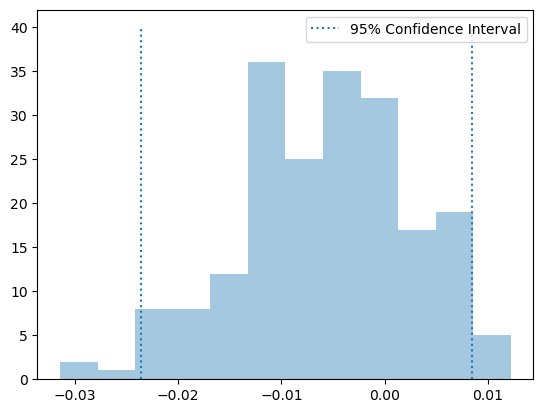

In [78]:
sns.distplot(dr_atets, kde=False)
plt.vlines(np.percentile(dr_atets, 2.5), 0, 40, linestyles="dotted")
plt.vlines(np.percentile(dr_atets, 97.5), 0, 40, linestyles="dotted", label="95% Confidence Interval")
plt.legend();

[Model 11] Double Machine Learning

In [79]:
controls_matching = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']

dml_data = ml_data.copy()
list_x = controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921'] + ['above_median1921']

dml_x = dml_data[list_x]
dml_y = dml_data['violence_episode_total'] 
dml_x_train, dml_x_test, dml_y_train, dml_y_test = train_test_split(dml_x, dml_y, test_size=0.25, random_state=random_st)
dml_train = pd.concat([dml_x_train, dml_y_train], axis=1)
dml_test = pd.concat([dml_x_test, dml_y_test], axis=1)
dml_bias = LGBMRegressor(max_depth=3, random_state = random_st)

In [80]:
dml_y = "violence_episode_total"
dml_t = "above_median1921"
dml_x =  controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921']

dml_noise = LGBMRegressor(max_depth=3, random_state = random_st)


In [81]:
dml_train_nonlin = dml_train.copy()
dml_test_nonlin = dml_test.copy()

dml_train_pred_nonlin = dml_train_nonlin.assign(exp_res =  
                                              dml_train_nonlin[dml_t] - 
                                              cross_val_predict(dml_bias, dml_train_nonlin[dml_x], dml_train_nonlin[dml_t], cv=5),
                          dep_res = dml_train_nonlin[dml_y] - 
                                              cross_val_predict(dml_noise, dml_train_nonlin[dml_x], dml_train_nonlin[dml_y], cv=5))

dml_nonlin = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 39684, number of used features: 13
[LightGBM] [Info] Start training from score 0.499345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [82]:
dml_wgt = dml_train_pred_nonlin["exp_res"] ** 2 
 
dml_y_st = (dml_train_pred_nonlin["dep_res"] / dml_train_pred_nonlin["exp_res"])

dml_nonlin.fit(X=dml_train_pred_nonlin[dml_x], y=dml_y_st, sample_weight=dml_wgt);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 49605, number of used features: 13
[LightGBM] [Info] Start training from score 0.002750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [83]:
dml_test_nonlin_cate = dml_test_nonlin.assign(dml_nonlin_cate=dml_nonlin.predict(dml_test_nonlin[dml_x]))

dml_ate_nonlin = dml_test_nonlin_cate['dml_nonlin_cate'].mean()
print(dml_ate_nonlin)

-0.006588459702133155


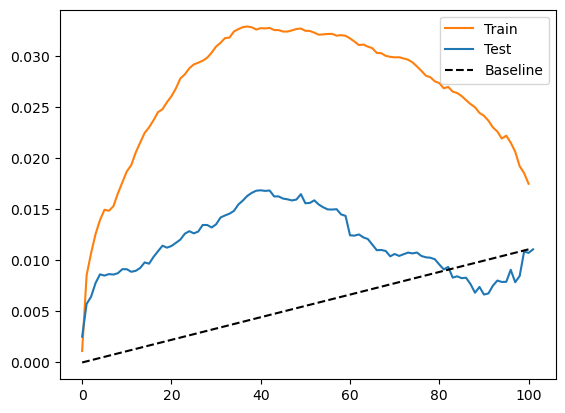

In [84]:
gain_curve_train_non_param = cumulative_gain(dml_train_nonlin.assign(dml_nonlin_cate=dml_nonlin.predict(dml_train_nonlin[dml_x])), 
                                             "dml_nonlin_cate", y=dml_y, t=dml_t)
gain_curve_test_non_param = cumulative_gain(dml_test_nonlin_cate, "dml_nonlin_cate", y=dml_y, t=dml_t)
plt.plot(gain_curve_train_non_param, color="C1", label="Train")
plt.plot(gain_curve_test_non_param, color="C0", label="Test")
plt.plot([0, 100], [0, elast(dml_test, dml_y, dml_t)], linestyle="--", color="black", label="Baseline")
plt.legend();

Text(0, 0.5, 'Estimated CATE')

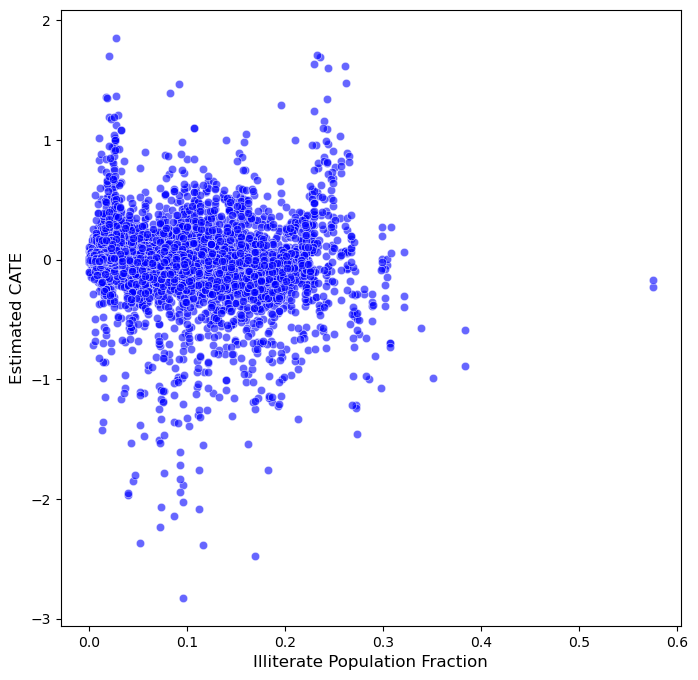

In [85]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=dml_test_nonlin_cate, x='illit_share', y='dml_nonlin_cate', color='blue', alpha=0.6)
plt.xlabel("Illiterate Population Fraction", fontsize =12)
plt.ylabel("Estimated CATE", fontsize =12)

In [86]:
sim_dml_data = dml_data.copy()

sim_dml_data['illit_share'] = sim_dml_data['illit_share'].rank(pct=True)
sim_dml_x = sim_dml_data[list_x]
sim_dml_y = sim_dml_data['violence_episode_total'] 
sim_dml_x_train, sim_dml_x_test, sim_dml_y_train, sim_dml_y_test = train_test_split(sim_dml_x, sim_dml_y, test_size=0.25, random_state=random_st)
sim_dml_train = pd.concat([sim_dml_x_train, sim_dml_y_train], axis=1)
sim_dml_test = pd.concat([sim_dml_x_test, sim_dml_y_test], axis=1)

In [87]:
dml_y = "violence_episode_total"
dml_t = "above_median1921"
dml_x =  controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921']

sim_dml_train_nonlin = sim_dml_train.copy()
sim_dml_test_nonlin = sim_dml_test.copy()

sim_dml_train_pred_nonlin = sim_dml_train_nonlin.assign(exp_res =  
                                              sim_dml_train_nonlin[dml_t] - 
                                              cross_val_predict(dml_bias, sim_dml_train_nonlin[dml_x], sim_dml_train_nonlin[dml_t], cv=5),
                          dep_res = sim_dml_train_nonlin[dml_y] - 
                                              cross_val_predict(dml_noise, sim_dml_train_nonlin[dml_x], sim_dml_train_nonlin[dml_y], cv=5))

sim_dml_nonlin = LGBMRegressor(max_depth=lgbm_max, min_child_samples=child, learning_rate =learn_rate, random_state=random_st)
 
sim_dml_wgt = sim_dml_train_pred_nonlin["exp_res"] ** 2 
 
sim_dml_y_st = (sim_dml_train_pred_nonlin["dep_res"] / sim_dml_train_pred_nonlin["exp_res"])

sim_dml_nonlin.fit(X=sim_dml_train_pred_nonlin[dml_x], y=sim_dml_y_st, sample_weight=sim_dml_wgt);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 39684, number of used features: 13
[LightGBM] [Info] Start training from score 0.499345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [88]:
sim_dml_test_nonlin_cate = sim_dml_test_nonlin.assign(dml_nonlin_cate=sim_dml_nonlin.predict(sim_dml_test_nonlin[dml_x]))

sim_dml_ate_nonlin = sim_dml_test_nonlin_cate['dml_nonlin_cate'].mean()
print(sim_dml_ate_nonlin)

-0.0027249613912302953


Text(0, 0.5, 'Estimated CATE')

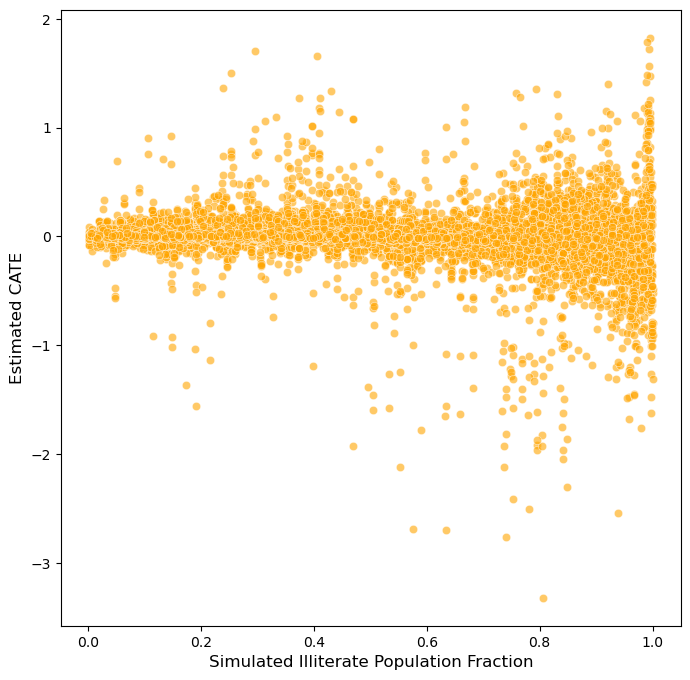

In [89]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=sim_dml_test_nonlin_cate, x='illit_share', y='dml_nonlin_cate', color='orange', alpha=0.6)

plt.xlabel("Simulated Illiterate Population Fraction", fontsize = 12)
plt.ylabel("Estimated CATE", fontsize = 12)

[Model 12] Causal Forest

In [90]:
hte_data = ml_data.copy()

controls_matching = ['avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 
                     'BBC_SNR_Ratio', 'popul_000s', 'female_share', 'illit_share']

all_x = controls_matching + [party for party in parties_1921 if party != 'aggregated_share1921'] + ['above_median1921']

In [91]:
hte_x = hte_data[all_x].values
hte_t = hte_data['above_median1921'].values.reshape(-1, 1)
hte_y = hte_data['violence_episode_total'].values.reshape(-1, 1)

hte_x_test = hte_x[:5000].copy()
hte_x_test[:, 0] = np.linspace(np.percentile(hte_x[:, 0], 1), np.percentile(hte_x[:, 0], 99), 5000)

In [92]:
treatment_model = LGBMRegressor(max_depth=3, random_state = random_st)
treatment_model.fit(hte_x, hte_t)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2583
[LightGBM] [Info] Number of data points in the train set: 66141, number of used features: 14
[LightGBM] [Info] Start training from score 0.499962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMRegressor(max_depth=3, random_state=55)

In [95]:
est = CausalForest(criterion='het', 
                   n_estimators=500, 
                   min_samples_leaf=50, 
                   min_balancedness_tol=.5,
                   max_depth=5, 
                   max_samples=0.25, 
                   inference=True, 
                   fit_intercept=True, 
                   subforest_size=5,
                   honest=True, 
                   verbose=0, 
                   n_jobs=-1, 
                   random_state=88)


est.fit(hte_x, hte_t, hte_y)

avg, lower, upper = est.predict(hte_x_test, interval=True, alpha=0.05)

hte = est.predict(hte_x_test) 

Text(0, 0.5, 'Frequency')

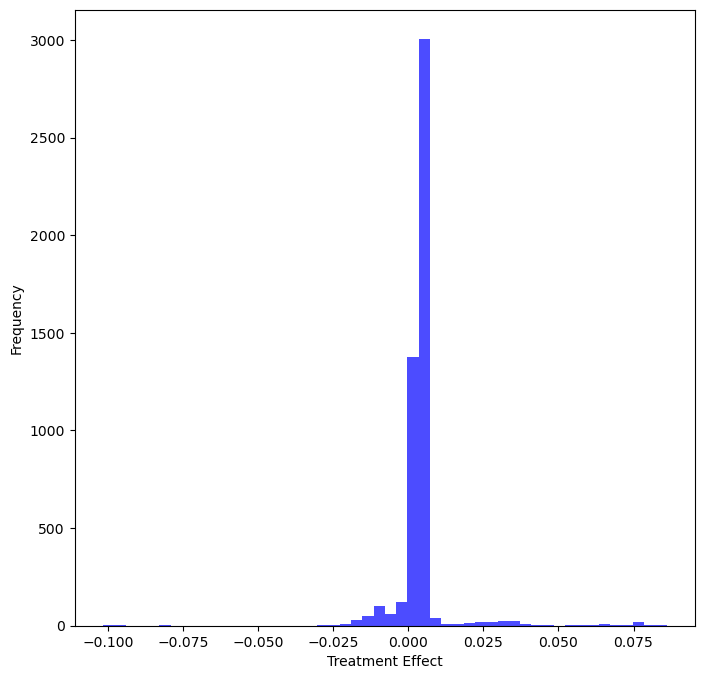

In [96]:
plt.figure(figsize=(8, 8))
plt.hist(avg, bins=50, color='blue', alpha=0.7) 
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')

Text(0, 0.5, 'HTE Estimate')

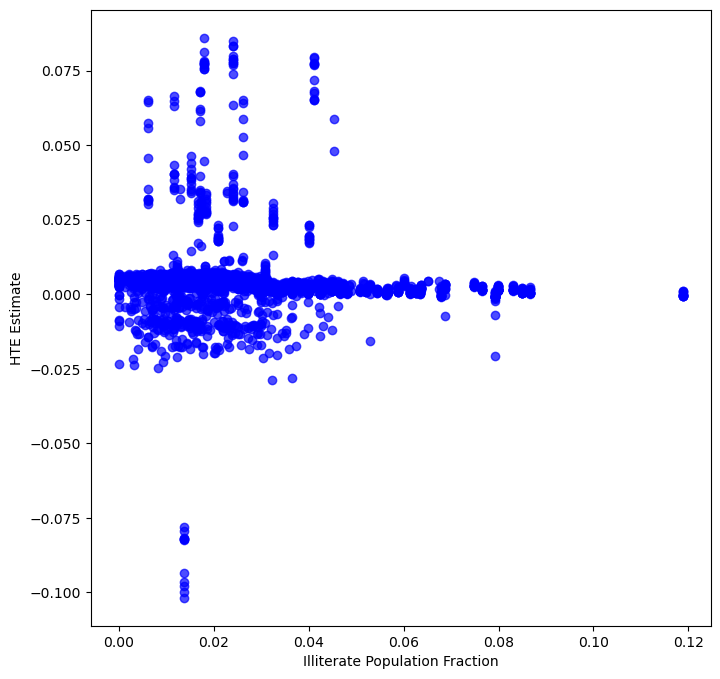

In [97]:
hte_illit = hte_x_test[:, all_x.index('illit_share')]

plt.figure(figsize=(8, 8))
plt.scatter(hte_illit[np.argsort(hte_illit)], hte[np.argsort(hte_illit)], alpha = 0.7, color='blue')
plt.xlabel('Illiterate Population Fraction')
plt.ylabel('HTE Estimate')

Text(0, 0.5, 'HTE Estimate')

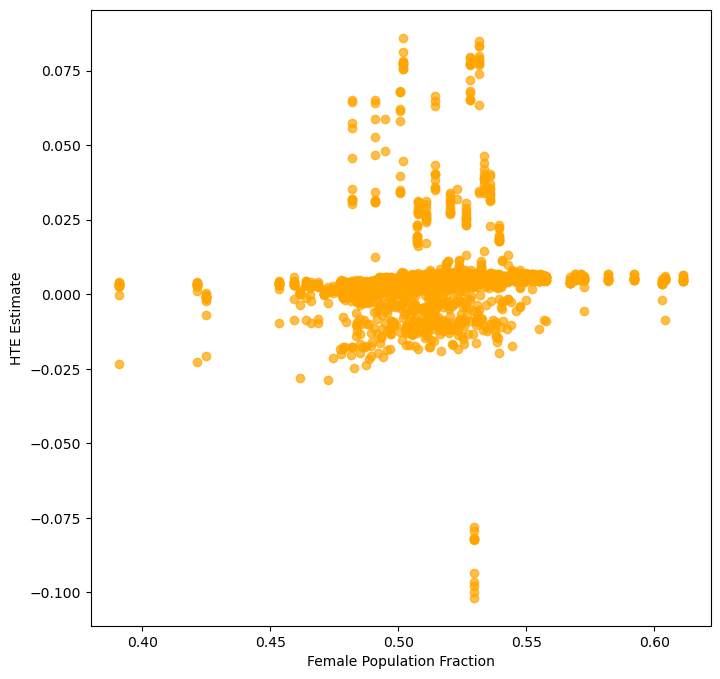

In [98]:
hte_female = hte_x_test[:, all_x.index('female_share')]

plt.figure(figsize=(8, 8))
plt.scatter(hte_female[np.argsort(hte_female)], hte[np.argsort(hte_female)], color='orange', alpha = 0.7)
plt.xlabel('Female Population Fraction')
plt.ylabel('HTE Estimate')